# PRODUCT SALES ANALYSIS

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

seed = 42

In [116]:
df = pd.read_csv('product_sales.csv')

# Data Validation

## Quick Overview
Using head(), info(), describe() and .isna().sum() we take a quick look at the dataframe, its datatypes and its null values.

In [117]:
SELECT *
FROM 'product_sales.csv'
LIMIT 5;

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NA,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NA,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


In [118]:
df.head(15)

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois
5,6,Call,6489e678-40f2-4fed-a48e-d0dff9c09205,13,65.01,10,24,Mississippi
6,4,Email,eb6bd5f1-f115-4e4b-80a6-5e67fcfbfb94,11,113.38,9,28,Georgia
7,1,Email,047df079-071b-4380-9012-2bfe9bce45d5,10,99.94,1,22,Oklahoma
8,5,Email,771586bd-7b64-40be-87df-afe884d2af9e,11,108.34,10,31,Massachusetts
9,5,Call,56491dae-bbe7-49f0-a651-b823a01103d8,11,53.82,7,23,Missouri


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [120]:
# Check for outliers and strange values
df.describe()

,week,nb_sold,revenue,years_as_customer,nb_site_visits
count,15000.000000,15000.000000,13926.000000,15000.000000,15000.000000
mean,3.098267,10.084667,93.934943,4.965933,24.990867
std,1.656420,1.812213,47.435312,5.044952,3.500914
min,1.000000,7.000000,32.540000,0.000000,12.000000
25%,2.000000,9.000000,52.470000,1.000000,23.000000
50%,3.000000,10.000000,89.500000,3.000000,25.000000
75%,5.000000,11.000000,107.327500,7.000000,27.000000
max,6.000000,16.000000,238.320000,63.000000,41.000000


In [121]:
# Check NaN
df.isna().sum()

week                    0
sales_method            0
customer_id             0
nb_sold                 0
revenue              1074
years_as_customer       0
nb_site_visits          0
state                   0
dtype: int64

## Week column
Using SQL'S COUNT() and pandas' value_counts(), we check the week column's values. This column seems to be OK, with weeks from 1 to 6, and no null values.

In [122]:
SELECT
	week,
	COUNT(week) AS count,
	COUNT(week) - COUNT(*) AS null_count
FROM 'product_sales.csv'
GROUP BY week
ORDER BY week ASC;

,week,count,null_count
0,1,3721,0
1,2,2491,0
2,3,2411,0
3,4,2575,0
4,5,2574,0
5,6,1228,0


In [123]:
df['week'].value_counts()

1    3721
4    2575
5    2574
2    2491
3    2411
6    1228
Name: week, dtype: int64

## Sales Method column
Problem with the values in a few rows: "em + call" should be "Email + Call", and "email" should be "Email". This was detected with pandas' value_counts() and fixed with pandas' replace().

In [124]:
df['sales_method'].value_counts()

Email           7456
Call            4962
Email + Call    2549
em + call         23
email             10
Name: sales_method, dtype: int64

In [125]:
df['sales_method'].replace('em + call','Email + Call', inplace=True)
df['sales_method'].replace('email','Email', inplace=True)
df['sales_method'].value_counts()

Email           7466
Call            4962
Email + Call    2572
Name: sales_method, dtype: int64

## Customer_ID column
Using SQL's LIKE, checked that the customer IDs all followed the same pattern: (8 characters)-(4 characters)-(4 characters)-(4 characters)-(12 characters). Using panda's nunique(), checked that all the IDs are unique, i.e. no customers have the same ID. 

In [126]:
-- Check if all customer IDs have the same format
SELECT COUNT(customer_id) FROM 'product_sales.csv'
WHERE customer_id LIKE '________-____-____-____-____________'

,count(customer_id)
0,15000


In [127]:
df['customer_id'].nunique()

15000

## Number Sold column
Using pandas' value_counts(), checked the values that are present in the dataset. We've already seen that there are no null values here using isna().sum() above.

In [128]:
df['nb_sold'].value_counts()

10    3677
9     3535
11    2439
8     1941
12    1088
13     939
7      698
15     555
14      97
16      31
Name: nb_sold, dtype: int64

## Revenue column
With our previous use of .isna().sum(), we know that here we have 1074 null values. Given that these rows are not 0 or Null on the "nb_sold" column, they do represent sales, so I will not assume that the null revenues represent zeroes (if items were sold then there should be revenue). Further, they account for more than 5% of the data. Thus I will impute by the mean _of each sales method separately_.

In [129]:
pct_null_revenue = 100*(df['revenue'].isna().sum()/len(df))
print('Percentage of Null Values: {:.2f}%'.format(pct_null_revenue))

Percentage of Null Values: 7.16%


In [130]:
mean_rev_by_method = df.groupby('sales_method')['revenue'].mean()

def impute_null_with_mean(row):
    if pd.isnull(row['revenue']):
        return round(mean_rev_by_method[row['sales_method']], 2)
    else:
        return row['revenue']

df['revenue'] = df.apply(impute_null_with_mean, axis=1)

In [131]:
# Take another quick look
df.head(150)

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,97.13,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,97.13,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois
...,...,...,...,...,...,...,...,...
145,1,Email,a0b8facb-0ed7-457b-a0a5-b3e6e5f365dd,8,83.36,4,17,Louisiana
146,3,Email,70636d4d-b39e-44a3-82a4-d11b88463bea,9,88.62,9,22,Pennsylvania
147,3,Email,a75bfa65-d465-4ea0-b5f2-7a34cb875373,9,93.86,0,27,Florida
148,2,Call,d7d2fb19-d5b1-4d93-95e6-e7b238ac05c2,9,46.56,0,28,Alabama


## Years as Customer column
Using pandas' value_counts(), checked all the values for this column. It seems to have no issues.

In [132]:
df['years_as_customer'].value_counts()

1     2504
2     1987
3     1619
0     1471
4     1338
5     1118
6      918
7      709
8      608
9      509
10     405
11     318
12     284
13     239
14     167
15     150
16     123
17      88
18      82
19      58
20      54
22      43
21      37
24      27
26      22
23      21
25      19
27      15
30       9
33       8
34       8
28       8
31       6
32       5
29       5
35       5
36       4
39       3
38       2
37       2
63       1
47       1
Name: years_as_customer, dtype: int64

## Number of Site Visits column
Using pandas' value_counts(), checked all the values for this column. It seems to have no issues.

In [133]:
df['nb_site_visits'].value_counts()

25    1688
26    1645
24    1601
23    1478
27    1440
22    1200
28    1175
21     908
29     893
30     654
20     600
19     426
31     371
32     250
18     217
33     114
17     113
16      80
34      51
35      33
15      31
36      14
14       7
37       5
13       4
12       1
41       1
Name: nb_site_visits, dtype: int64

## State column
Here I made another dataframe, where the index are the states, and the only other column is the count of rows that have that state. Verifying this dataframe made it clear that the column State has no issues.

In [134]:
state = pd.DataFrame(df['state'].value_counts())
state.rename(columns={'state':'count'}, inplace = True)
state.rename_axis('state', inplace=True)
state.sort_index()

,count
state,
Alabama,214
Alaska,40
Arizona,321
Arkansas,132
California,1872
Colorado,230
Connecticut,179
Delaware,34
Florida,904


# Exploratory Analysis

## Correlation Heatmap
A correlation heatmap will give us strong hints as to what variables we need to look into.

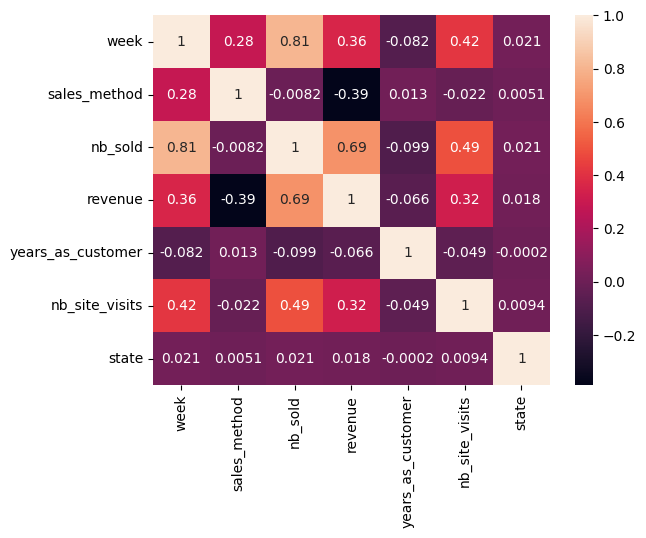

In [135]:
# We need to numerically encode the categories to check for correlation using a heatmap
sales_methods = df['sales_method'].unique() # list of sales methods
states = df['state'].unique() # list of states

sales_method_numbers = {}
states_numbers = {}
for i in range(len(sales_methods)):
    sales_method_numbers[sales_methods[i]] = i
for i in range(len(states)):
    states_numbers[states[i]] = i
    
df_encoded = df.replace({'sales_method':sales_method_numbers, 'state':states_numbers})

sns.heatmap(df_encoded[['week','sales_method','nb_sold','revenue','years_as_customer','nb_site_visits','state']].corr(), annot=True)
plt.show()

Notable correlations:
- Sales Method and Week (+0.28)
- Number Sold and Week (+0.81)
- Revenue and Week (+0.28)
- Site Visits and Week (+0.42)
- Revenue and Sales Method (-0.33)
- Revenue and Number Sold (+0.54)
- Site Visits and Number Sold (+0.49)
- Site Visits and Revenue (+0.25)

## Customers per Sales Method

In [136]:
cust_per_method = pd.DataFrame(df['sales_method'].value_counts())
cust_per_method.rename(columns={'sales_method':'count'}, inplace=True)
cust_per_method.rename_axis('sales_method', inplace=True)
cust_per_method

,count
sales_method,
Email,7466
Call,4962
Email + Call,2572


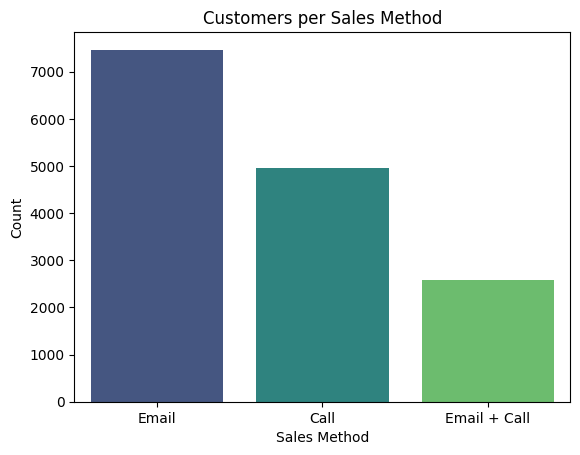

In [137]:
sns.barplot(data = cust_per_method, x = 'sales_method', y = 'count', palette=sns.color_palette('viridis', 3))
plt.title('Customers per Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Count')
plt.show()

- A great number of customers (7000+) are contacted via Email, which is a very low-cost method resource-wise.
- A significant number of customers (~5000) are contacted via Call, which is expensive in terms of resources.
- A relatively low number of customers (~3000) are contacted via Email+Call, which is somewhat low in costs.

## Sales Method and Week
How does the number of customers contacted via each method change throughout the weeks?

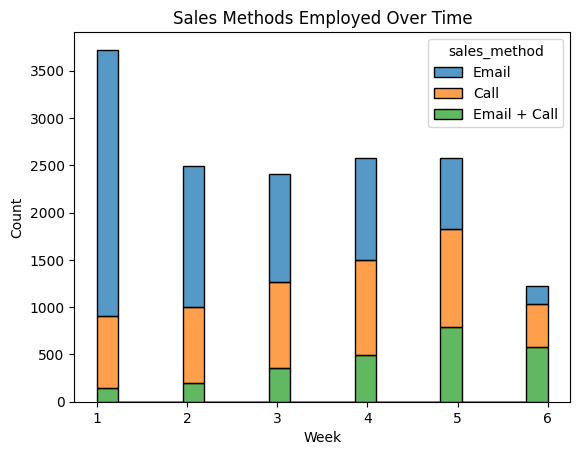

In [138]:
sm_week = df[['sales_method','week']]
sns.histplot(data = sm_week, x='week', hue='sales_method', hue_order=['Email','Call','Email + Call'], multiple='stack')
plt.title('Sales Methods Employed Over Time')
plt.xlabel('Week')
plt.ylabel('Count')
plt.show()

- We can see that the company contacted less clients through Email after week 1, and even less after week 5.
- The company also had a slight increase in Call and Email+Call methods through weeks 1-5, followed by a subsequent decrease in both.
- It is important to point out these differences, since they will certainly interfere with our metrics of interest, such as the revenue for each method. **If a method is less used, it will likely generate less revenue.**
- Thus we ought to look at the _proportion_ of revenue for each method, based on how many clients it was used on.
- Therefore, we shall define a new dataframe with the revenue for each method being divided by the number of clients contacted via said method, for each week separetely.

In [139]:
# Define dataframe with proportions for number of clients contacted via each method
df_prop = df.copy(deep=True)

for week in range(1,7):
    email_count = len(df.loc[ (df['sales_method']=='Email') & (df['week']==week) ])
    call_count  = len(df.loc[ (df['sales_method']=='Call') & (df['week']==week) ])
    both_count  = len(df.loc[ (df['sales_method']=='Email + Call') & (df['week']==week) ])

    df_prop.loc[(df_prop['sales_method']=='Email') & (df_prop['week']==week), 'revenue'] /= email_count
    df_prop.loc[(df_prop['sales_method']=='Call') & (df_prop['week']==week), 'revenue'] /= call_count
    df_prop.loc[(df_prop['sales_method']=='Email + Call') & (df_prop['week']==week), 'revenue'] /= both_count

    df_prop.loc[(df_prop['sales_method']=='Email') & (df_prop['week']==week), 'nb_site_visits'] /= email_count
    df_prop.loc[(df_prop['sales_method']=='Call') & (df_prop['week']==week), 'nb_site_visits'] /= call_count
    df_prop.loc[(df_prop['sales_method']=='Email + Call') & (df_prop['week']==week), 'nb_site_visits'] /= both_count

df_prop.head(10)

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,0.065363,0,0.016151,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,0.386741,1,0.048027,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,0.050335,6,0.024904,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,0.090353,3,0.023256,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,0.078687,0,0.024348,Illinois
5,6,Call,6489e678-40f2-4fed-a48e-d0dff9c09205,13,0.145112,10,0.053571,Mississippi
6,4,Email,eb6bd5f1-f115-4e4b-80a6-5e67fcfbfb94,11,0.105470,9,0.026047,Georgia
7,1,Email,047df079-071b-4380-9012-2bfe9bce45d5,10,0.035503,1,0.007815,Oklahoma
8,5,Email,771586bd-7b64-40be-87df-afe884d2af9e,11,0.145814,10,0.041723,Massachusetts
9,5,Call,56491dae-bbe7-49f0-a651-b823a01103d8,11,0.051552,7,0.022031,Missouri


## Spread of Revenue

### Overall

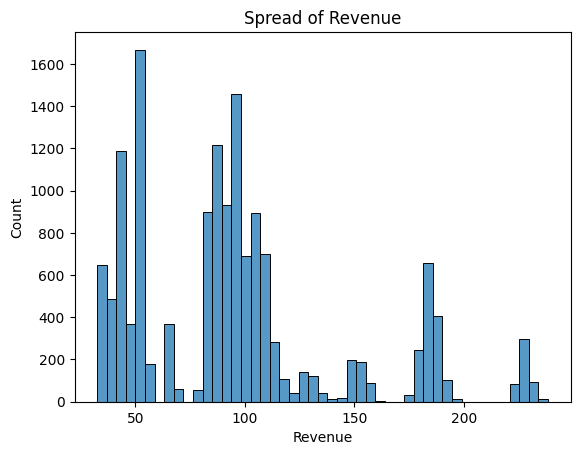

In [140]:
sns.histplot(data=df, x='revenue')
plt.title('Spread of Revenue')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

### Per Method

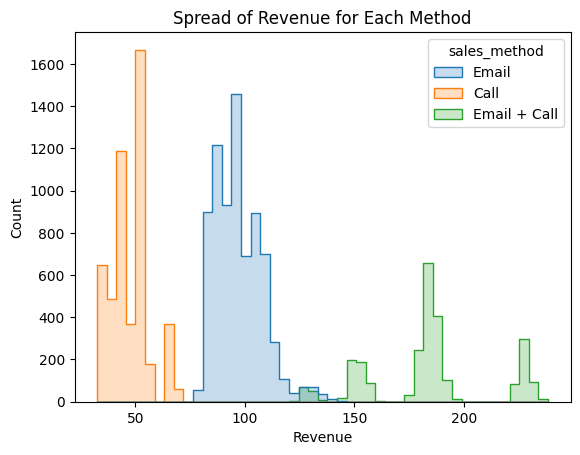

In [141]:
sns.histplot(data=df, x='revenue', hue='sales_method', hue_order=['Email', 'Call', 'Email + Call'], element='step')
plt.title('Spread of Revenue for Each Method')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.show()

- The Email method produced intermediate revenue
- The Call method produced low revenue
- The Email+Call method produced high revenue

## Revenue Over Time

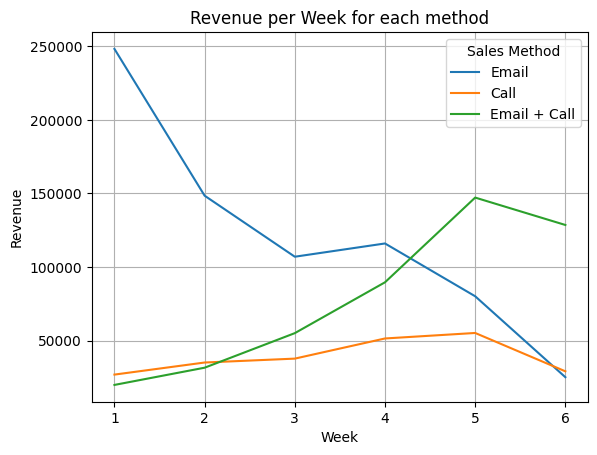

In [142]:
rev_time = df[['week','sales_method','revenue']]
rev_time = rev_time.groupby(['week', 'sales_method']).sum()

sns.lineplot(data=rev_time, x='week', y='revenue', hue='sales_method', hue_order = ['Email', 'Call', 'Email + Call'], markers=True)
plt.title('Revenue per Week for each method')
plt.ylabel('Revenue')
plt.xlabel('Week')
plt.grid(True)
plt.legend(title='Sales Method')
plt.show()

It could be that this graph presents bias due to the difference in the amount of customers contacted through each method, so we shall make a similar analysis with using the proportion of revenue instead.

## Revenue Over Time, proportionally to number of clients

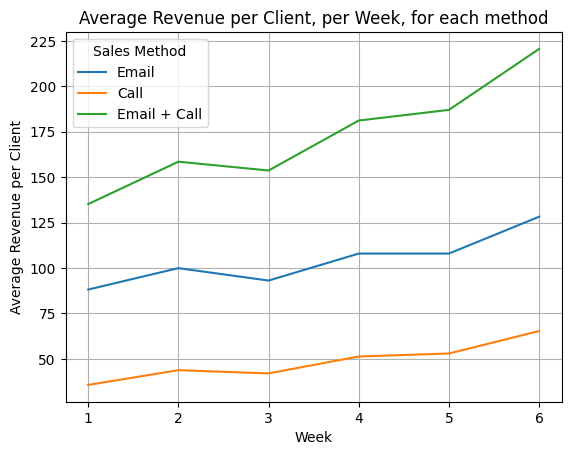

In [143]:
rev_time_prop = df_prop[['week','sales_method','revenue']]
rev_time_prop = rev_time_prop.groupby(['week', 'sales_method']).sum()

sns.lineplot(data=rev_time_prop, x='week', y='revenue', hue='sales_method', hue_order = ['Email', 'Call', 'Email + Call'], markers=True)
plt.title('Average Revenue per Client, per Week, for each method')
plt.ylabel('Average Revenue per Client')
plt.xlabel('Week')
plt.grid(True)
plt.legend(title='Sales Method')
plt.show()

In stark contrast to the previous graph, here it is clear that:
- The average Email revenue per client was average and increased slightly over the weeks, instead of decreasing drastically as the previous graph suggested.
- The average Call revenue per client was low and increased very slightly over the weeks.
- The average Email + Call revenue per client was high and increased significantly over the weeks.

## Site Visits Over Time

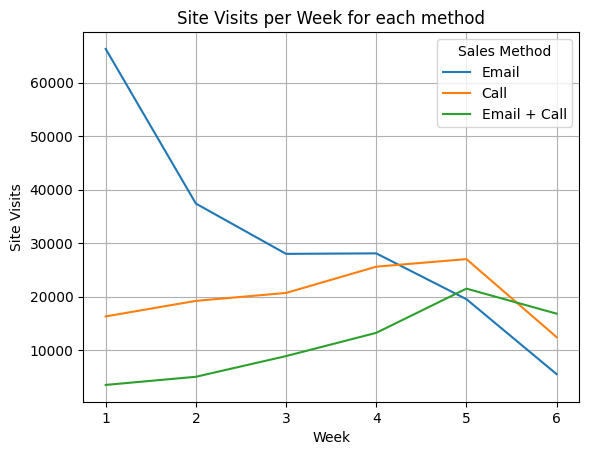

In [144]:
visits_time = df[['week','sales_method','nb_site_visits']]
visits_time = visits_time.groupby(['week', 'sales_method']).sum()

sns.lineplot(data=visits_time, x='week', y='nb_site_visits', hue='sales_method', hue_order = ['Email', 'Call', 'Email + Call'], markers=True)
plt.title('Site Visits per Week for each method')
plt.ylabel('Site Visits')
plt.xlabel('Week')
plt.grid(True)
plt.legend(title='Sales Method')
plt.show()

Again we will perform an analysis taking the proportion of clients into account.

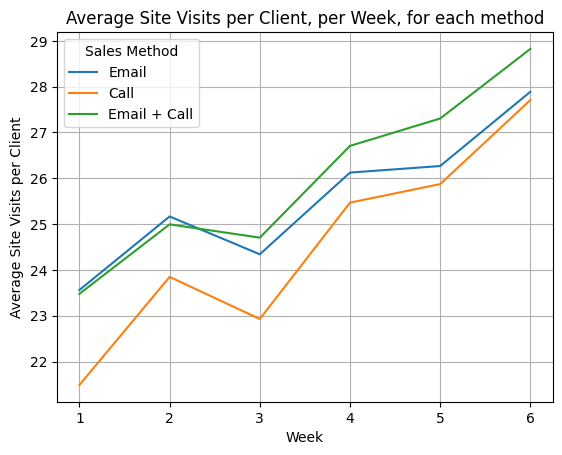

In [145]:
visits_time_prop = df_prop[['week','sales_method','nb_site_visits']]
visits_time_prop = visits_time_prop.groupby(['week', 'sales_method']).sum()

sns.lineplot(data=visits_time_prop, x='week', y='nb_site_visits', hue='sales_method', hue_order = ['Email', 'Call', 'Email + Call'], markers=True)
plt.title('Average Site Visits per Client, per Week, for each method')
plt.ylabel('Average Site Visits per Client')
plt.xlabel('Week')
plt.grid(True)
plt.legend(title='Sales Method')
plt.show()

All three methods showed an increase in the average site visits per client throughout the weeks. Again, the Email + Call method proved superior, followed by Email and then Call.

## Site Visits and Revenue

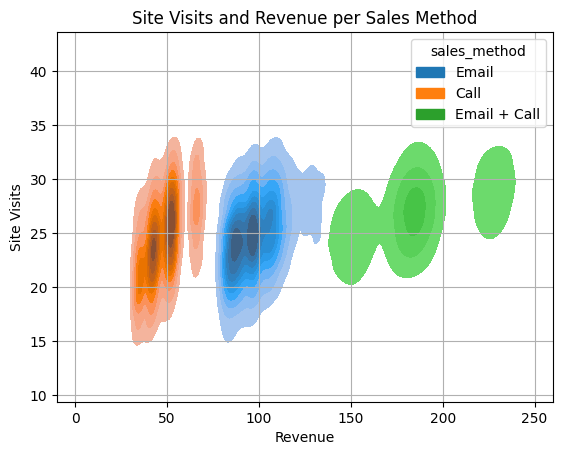

In [146]:
sv_rev = df[['nb_site_visits','revenue','sales_method']]
sns.kdeplot(data = sv_rev, x='revenue', y='nb_site_visits', hue='sales_method', hue_order=['Email','Call','Email + Call'], fill=True)
plt.title('Site Visits and Revenue per Sales Method')
plt.xlabel("Revenue")
plt.ylabel("Site Visits")
plt.grid(True)
plt.xlim(-10,260)
plt.show()

# Business Metric

It is clear that one should not think simply in terms of how much revenue each method generated, without considering how many clients where contacted via each method. It is when taking these proportions into account that the true efficiency of each method is shown. Therefore, the main business metrics taken by the business should be:
- Average revenue per client per week of each method
- Number of clients per week of each method
- Total revenue per week

In [147]:
# Current metrics
email_rev = df_prop.loc[df_prop['sales_method']=='Email', 'revenue'].sum()
call_rev  = df_prop.loc[df_prop['sales_method']=='Call', 'revenue'].sum()
both_rev  = df_prop.loc[df_prop['sales_method']=='Email + Call', 'revenue'].sum()

client_counts = df['sales_method'].value_counts()
email_clients = client_counts['Email']/6
call_clients = client_counts['Call']/6
both_clients = client_counts['Email + Call']/6

rev_per_week = df['revenue'].sum()/6

print("Average Email-method revenue per client per week: {:.2f}".format(email_rev))
print("Average Call-method revenue per client per week: {:.2f}".format(call_rev))
print("Average Email+Call-method revenue per client per week: {:.2f}".format(both_rev))

print('=======================')

print("Average Email-method clients per week: {:.2f}".format(email_clients))
print("Average Call-method clients per week: {:.2f}".format(call_clients))
print("Average Email+Call-method clients per week: {:.2f}".format(both_clients))

print('=======================')

print("Average revenue per week: {:.2f}".format(rev_per_week))

Average Email-method revenue per client per week: 625.27
Average Call-method revenue per client per week: 290.91
Average Email+Call-method revenue per client per week: 1036.15
Average Email-method clients per week: 1244.33
Average Call-method clients per week: 827.00
Average Email+Call-method clients per week: 428.67
Average revenue per week: 238947.70


# Summary & Recommendations

Based on the data:
- **Call method**: Requires _many resources_ (30 min calls) and gives the _least revenue_. It could be _discarded_ in favour of the other two methods.

- **Email method**: Requires _virtually no resources_, yet generates a _signifcant amount of revenue_. There seems to be no reason to stop it.

- **Email+Call method**: Requires _intermediate resources_ (10 min calls), but returns _great revenue_. The company should look to improve and _expand on this method_.